In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cuda device


In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

The mobilenet v1 is implemented below.
Reference links: 
1. https://towardsdatascience.com/review-mobilenetv1-depthwise-separable-convolution-light-weight-model-a382df364b69

2. https://arxiv.org/pdf/1704.04861v1.pdf

For mobilnet v2:

```
mobilenet = models.mobilenet_v2(pretrained=True)
```
![image.png](https://miro.medium.com/max/938/1*ylHiMKAXb57bN7uDhzldlg.png)
![img.png](https://drive.google.com/uc?export=view&id=1elEnrh_MAWIk1s5eOF7zffn-Fb0fWl45)

There is a mistake.. stride for the last depthwise_conv layer should be 1 and not 2. 

In [ ]:
def standard_conv(input_channels , output_channels, stride):
    model = nn.Sequential(
        nn.Conv2d(
            in_channels=input_channels, 
            out_channels=output_channels, 
            kernel_size=3, 
            stride = stride, 
            padding = 1, 
            bias=False),
        nn.BatchNorm2d(num_features=output_channels),
        nn.ReLU(inplace=True)
    )
    return model

In [ ]:
def depthwise_conv(input_channels , output_channels, stride):
    model = nn.Sequential(
        # depthwise convolution
        # this is ensured by making groups = input_channels
        nn.Conv2d(
            in_channels = input_channels, 
            out_channels = input_channels, 
            kernel_size=3, 
            stride = stride, 
            padding = 1, 
            groups=input_channels, 
            bias=False),
        nn.BatchNorm2d(num_features=input_channels),
        nn.ReLU(inplace=True),

        # pointwise convolution
        nn.Conv2d(
            in_channels = input_channels, 
            out_channels = output_channels, 
            kernel_size = 1, 
            stride = 1, 
            padding = 0, 
            bias=False),
        nn.BatchNorm2d(num_features=output_channels),
        nn.ReLU(inplace=True),
    )
    return model

In [ ]:
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        self.conv_layers = nn.Sequential(
            standard_conv(input_channels = 3, output_channels = 32, stride = 2),
            depthwise_conv(input_channels = 32, output_channels = 64, stride = 1),
            depthwise_conv(input_channels = 64, output_channels = 128, stride = 2),
            depthwise_conv(input_channels = 128, output_channels = 128, stride = 1),
            depthwise_conv(input_channels = 128, output_channels = 256, stride = 2),
            depthwise_conv(input_channels = 256, output_channels = 256, stride = 1),
            depthwise_conv(input_channels = 256, output_channels = 512, stride = 2),
            depthwise_conv(input_channels = 512, output_channels = 512, stride = 1),
            depthwise_conv(input_channels = 512, output_channels = 512, stride = 1),
            depthwise_conv(input_channels = 512, output_channels = 512, stride = 1),
            depthwise_conv(input_channels = 512, output_channels = 512, stride = 1),
            depthwise_conv(input_channels = 512, output_channels = 512, stride = 1),
            depthwise_conv(input_channels = 512, output_channels = 1024, stride = 2),
            depthwise_conv(input_channels = 1024, output_channels = 1024, stride = 1),
            nn.AvgPool2d(kernel_size=7)
        )   
        self.fully_connected = nn.Linear(in_features=1024, out_features=1000)
        self.softmax = nn.Softmax(dim = 1) 

    def forward(self, x):
        '''
        # Debug Block (prints output size of each layer)
        for layer in self.conv_layers:
          x = layer(x)
          print(x.size())
        x = torch.reshape(x, (-1, 1024))
        print(x.size())
        x = self.fully_connected(x)
        print(x.size())
        x = self.softmax(x)
        print(x.size())

        # To run the block execute:
        # x = torch.randn(1, 3, 224, 224)
        # model(x)
        '''

        x = self.conv_layers(x)
        x = torch.reshape(x, (-1, 1024))
        x = self.fully_connected(x)
        x = self.softmax(x)
        
        return x

In [ ]:
# returns the mobilenetv1 initialized using pretrained weights on imagenet. lr = 0.1 bs = 256
def load_pretrained_mobilenet():
    model = MobileNet().to(device)
    model_filename = 'drive/MyDrive/Saidl Assignment/model_best.pth.tar'
    checkpoint = torch.load(model_filename, map_location = device)
    pretrained_dict = checkpoint['state_dict']
    for key in list(pretrained_dict.keys()):
        if 'model.' in key:
            pretrained_dict[key.replace('module.model.', 'conv_layers.')] = pretrained_dict[key]
            del pretrained_dict[key]
        if 'module.fc.' in key:
            pretrained_dict[key.replace('module.fc.', 'fully_connected.')] = pretrained_dict[key]
            del pretrained_dict[key]

    model.load_state_dict(pretrained_dict)

    # Freeze mobilenet
    for p in model.parameters():
        p.requires_grad = False

    # remove the average pooling layer
    # now the output after the last layer will be of shape 7 x 7 x 1024
    model = nn.Sequential(*(model.conv_layers[i] for i in range(14)))

    return model

In [ ]:
# increase the dimensions and decrease the number of channels using transpose convolution
def upsample_layer(input_channels, output_channels):
    stride = 2
    kernel_size = 5
    padding = 2
    output_padding = 1

    '''
    # approach 1: 
    # first depthwise transconv to increase dimensions, channels remain same
    # then pointwise to decrease channels, dims remain same
    '''
    model = nn.Sequential(
            # depthwise transconv, ensured using groups = channels
            nn.ConvTranspose2d(
                in_channels = input_channels,
                out_channels = input_channels,
                kernel_size = kernel_size,
                stride = stride,
                padding = padding,
                output_padding = output_padding,
                bias = False,
                groups = input_channels),
            nn.BatchNorm2d(num_features=input_channels),
            nn.ReLU(inplace=True),

            # pointwise
            nn.Conv2d(
                in_channels = input_channels, 
                out_channels = output_channels, 
                kernel_size = 1, 
                stride = 1, 
                padding = 0, 
                bias=False),
            nn.BatchNorm2d(num_features=output_channels),
            nn.ReLU(inplace=True)
        )
    
    '''
    # approach 2: 
    # normal transconv operation where dims and channel both are changed in one operation
    # this has more params than approach 1
    
    model = nn.Sequential(
            # depthwise transconv, ensured using groups = channels
            nn.ConvTranspose2d(
                in_channels = input_channels,
                out_channels = output_channels,
                kernel_size = kernel_size,
                stride = stride,
                padding = padding,
                output_padding = output_padding,
                bias=False),
            nn.BatchNorm2d(num_features=output_channels),
            nn.ReLU(inplace=True)
        )
    '''

    return model

In [ ]:
def get_layer_activations(model, activation):
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    for i in range(14):
        model[i].register_forward_hook(get_activation('conv_layers' + str(i)))
    '''
    # Debug Block: prints shape of each intermediate and final activation
    x = torch.randn(1, 3, 224, 224)
    output = model(x)
    for i in range(14):
      print(activation['conv_layers' + str(i)].shape)
    '''

In [ ]:
class FastDepth(nn.Module):
    def __init__(self):
        super(FastDepth, self).__init__()
        # mobilenet
        self.mobilenet = load_pretrained_mobilenet()
        self.activation = {} 
        get_layer_activations(self.mobilenet, self.activation)

        # upsample layers
        self.upsample1 = upsample_layer(1024, 512)
        self.upsample2 = upsample_layer(512, 256)
        self.upsample3 = upsample_layer(256, 128)
        self.upsample4 = upsample_layer(128, 64)
        self.upsample5 = upsample_layer(64, 32)
        self.pointwise = nn.Conv2d(
          in_channels = 32, 
          out_channels = 1, 
          kernel_size = 1, 
          stride = 1, 
          padding = 0, 
          bias=False)
        
    def forward(self, x):
        x = self.mobilenet(x)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x + self.activation['conv_layers5'])
        x = self.upsample4(x + self.activation['conv_layers3'])
        x = self.upsample5(x + self.activation['conv_layers1'])
        x = self.pointwise(x)
        return x

In [ ]:
model = FastDepth().to(device)
print(model)

FastDepth(
  (mobilenet): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1,

In [ ]:
# Debug Block
'''
x = torch.randn(1, 3, 224, 224)
target = torch.randn(1, 1, 224, 224)
output = model(x)
print(output.shape)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer.zero_grad()
output = model(x)
loss = loss_fn(output, target)
loss.backward()
optimizer.step()
'''

'\nx = torch.randn(1, 3, 224, 224)\ntarget = torch.randn(1, 1, 224, 224)\noutput = model(x)\nprint(output.shape)\n\nloss_fn = nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n\noptimizer.zero_grad()\noutput = model(x)\nloss = loss_fn(output, target)\nloss.backward()\noptimizer.step()\n'

In [ ]:
# Test Block
'''
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model = load_pretrained_mobilenet()
for i in range(14):
    model[i].register_forward_hook(get_activation('conv_layers' + str(i)))
x = torch.randn(1, 3, 224, 224)
output = model(x)
for i in range(14):
  print(activation['conv_layers' + str(i)].shape)
'''

"\nactivation = {}\ndef get_activation(name):\n    def hook(model, input, output):\n        activation[name] = output.detach()\n    return hook\n\n\nmodel = load_pretrained_mobilenet()\nfor i in range(14):\n    model[i].register_forward_hook(get_activation('conv_layers' + str(i)))\nx = torch.randn(1, 3, 224, 224)\noutput = model(x)\nfor i in range(14):\n  print(activation['conv_layers' + str(i)].shape)\n"

Loading the dataset

In [ ]:
%matplotlib inline 
from matplotlib import pyplot as plt
import h5py
import numpy as np

In [ ]:
filepath = 'drive/MyDrive/Saidl Assignment/nyu_depth_v2_labeled.mat'
arrays = {}
f = h5py.File(filepath)
#print(f[depths])
images = []
depths = []
for k, v in f.items():
    if k == 'images':
        images = v
    if k == 'depths':
        depths = v

In [ ]:
depths = np.array(depths)
images = np.array(images)
print(images.shape)
print(depths.shape)

(1449, 3, 640, 480)
(1449, 640, 480)


In [ ]:
d = np.expand_dims(depths, axis=-1)
d = np.moveaxis(d, 3, 1)
print(d.shape)

(1449, 1, 640, 480)


In [ ]:
im = np.moveaxis(images, 1, 3)
print(im.shape)

(1449, 640, 480, 3)


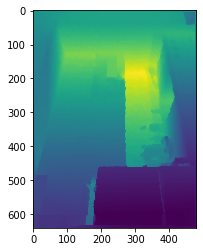

In [ ]:
plt.imshow(depths[1], interpolation='nearest')
plt.show()

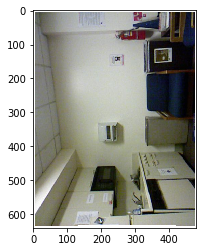

In [ ]:
plt.imshow(im[0], interpolation='nearest')
plt.show()

In [ ]:
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import torch

img = torch.from_numpy(images)
dep = torch.from_numpy(d)
#img = ToTensor()(img)
out_im = F.interpolate(img, (224,224))
out_dep = F.interpolate(dep, (224,224))
print(out_im.shape)
print(out_dep.shape)

torch.Size([1449, 3, 224, 224])
torch.Size([1449, 1, 224, 224])


In [ ]:
def show(img):
    npimg = img.numpy()
    
    if npimg.shape[0] == 1:
      npimg = np.squeeze(npimg)
      plt.imshow(npimg, interpolation='nearest')
    else:
      plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

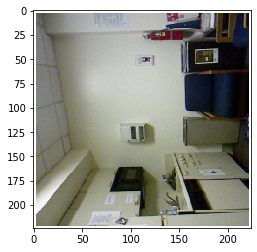

In [ ]:
show(out_im[0])

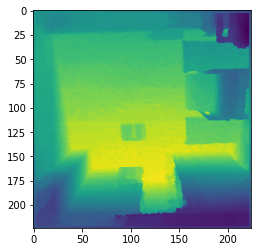

In [ ]:
show(out_dep[0])

In [ ]:
out_im_train = out_im[:900]
out_dep_train = out_dep[:900]
print(out_im_train.shape)
print(out_dep_train.shape)

out_im_val = out_im[900:1200]
out_dep_val = out_dep[900:1200]
print(out_im_val.shape)
print(out_dep_val.shape)

torch.Size([900, 3, 224, 224])
torch.Size([900, 1, 224, 224])
torch.Size([300, 3, 224, 224])
torch.Size([300, 1, 224, 224])


In [ ]:
def imshow(img, title=''):
    """Plot the image batch.
    """
    print(img.shape)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

In [ ]:
from torch.utils.data import Dataset, TensorDataset
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

torch.Size([3, 906, 906])


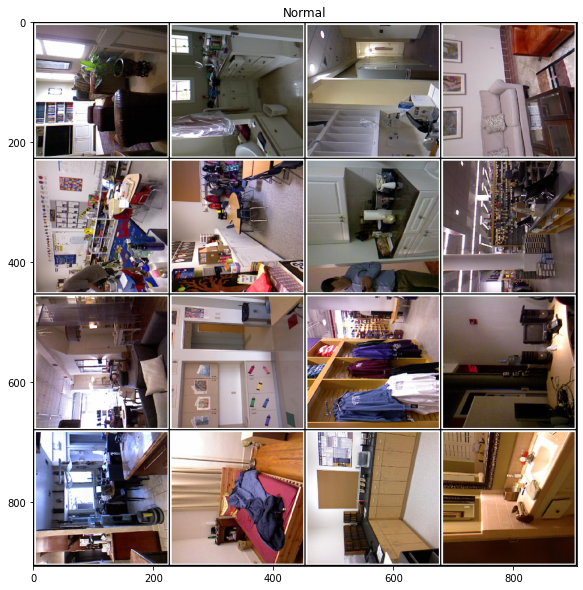

In [ ]:
import torchvision
train_dataset_normal = CustomTensorDataset(tensors=(out_im_train, out_dep_train), transform=None)
train_loader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=16, shuffle = True)

valid_dataset_normal = CustomTensorDataset(tensors=(out_im_val, out_dep_val), transform=None)
valid_loader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=16, shuffle = True)

# iterate
for i, data in enumerate(train_loader):
    x, y = data  
    imshow(torchvision.utils.make_grid(x, 4), title='Normal')
    break  # we need just one batch

In [ ]:
learning_rate = 1e-2
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
def train(x_train, model, loss_fn, optim):
    total_loss = 0.0
    accuracy = 0.0
    size = len(x_train.dataset)
    model.train()
    for batch,(x,y) in enumerate(x_train):
        x = x/255.0
        x,y = x.to(device), y.to(device)
        y_p = model(x)
        loss = loss_fn(y_p,y)
        total_loss +=loss.item()
        #accuracy += 
        optimizer.zero_grad()
        loss.backward()
        optim.step()
    total_loss = total_loss/size
    #accuracy = accuracy/size
    return total_loss, accuracy

In [ ]:
def test(x_test, model, loss_fn):
    total_loss = 0.0
    accuracy = 0.0
    size = len(x_test.dataset)
    model.eval()
    with torch.no_grad():
        for batch,(x,y) in enumerate(x_test):
            x = x/255.0
            x,y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            #accuracy+= 
            total_loss+= loss.item()
    total_loss = total_loss/size
    #accuracy = accuracy/size
    return total_loss,accuracy

In [ ]:
epoch = 10
train_loss =[]
train_acc = []
test_loss = []
test_acc = []

for i in range(0,epoch):
    loss,acc = train(train_loader ,model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)
    
    print("{}th iteration of training: Loss {} \t Accuracy {}".format(i,loss,acc*100))
    
    loss,acc = test(valid_loader, model, loss_fn)
    test_loss.append(loss)
    test_acc.append(acc)

0th iteration of training: Loss 0.07500313712490929 	 Accuracy 0.0
1th iteration of training: Loss 0.06663632227314843 	 Accuracy 0.0
2th iteration of training: Loss 0.06314092881149716 	 Accuracy 0.0
3th iteration of training: Loss 0.06063473383585612 	 Accuracy 0.0
4th iteration of training: Loss 0.052879164152675205 	 Accuracy 0.0
5th iteration of training: Loss 0.05013973093695111 	 Accuracy 0.0
6th iteration of training: Loss 0.044814276264773474 	 Accuracy 0.0
7th iteration of training: Loss 0.042066049377123514 	 Accuracy 0.0
8th iteration of training: Loss 0.038620872696240746 	 Accuracy 0.0
9th iteration of training: Loss 0.04086336142486996 	 Accuracy 0.0


In [ ]:
model.eval()
with torch.no_grad():
    x = out_im_val[:1].to(device)
    x = x/255.0
    pred = model(x)

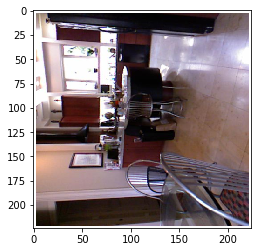

In [ ]:
show(out_im_val[0])

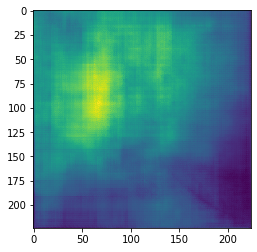

In [ ]:
show(pred.cpu())

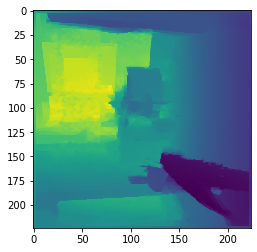

In [ ]:
show(out_dep_val[0])

In [ ]:
plt.figure(figsize=(4,5))
plt.title("Loss")
plt.plot(train_loss, 'r', label ='train loss')
plt.plot(test_loss, 'b', label = 'test loss')
plt.legend()